# Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient
from scipy.stats import norm
from datetime import datetime, timedelta
import random

from ab_testing.constants import client_name, target_col
from ab_testing.data_acquisition.acquire_data import queries_dict  # AcquireData
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from ab_testing.predictions.produce_predictions import ProducePredictions
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

In [2]:
configure_offline_feature_store(workgroup="development", catalog_name="production")

In [3]:
def run_ab_testing(data_df, dates_list):
    list_probabs_conv_test = []
    list_losses_conv_test_P = []
    list_losses_conv_test_C = []
    list_conversion_rates_P = []
    list_conversion_rates_C = []

    num_datapoints_P = 0
    num_datapoints_C = 0
    num_conversions_P = 0
    num_conversions_C = 0

    a_prior_conv_test_C = 0.5
    b_prior_conv_test_C = 0.5
    a_prior_conv_test_P = 0.5
    b_prior_conv_test_P = 0.5
    

    list_probabs_revenue_test = []
    list_losses_revenue_test_P = []
    list_losses_revenue_test_C = []
    list_average_spends_P = []
    list_average_spends_C = []

    sum_spends_P = 0
    sum_spends_C = 0

    a_prior_beta_revenue_test_P = 0.5
    b_prior_beta_revenue_test_P = 0.5
    m_prior_revenue_test_P = 1
    a_prior_ig_revenue_test_P = 0
    b_prior_ig_revenue_test_P = 0
    w_prior_revenue_test_P = 0.01

    a_prior_beta_revenue_test_C = 0.5
    b_prior_beta_revenue_test_C = 0.5
    m_prior_revenue_test_C = 1
    a_prior_ig_revenue_test_C = 0
    b_prior_ig_revenue_test_C = 0
    w_prior_revenue_test_C = 0.01


    for current_date in dates_list:
        print(current_date)
        daily_data = data_df[data_df.meta_date == current_date].copy()
        daily_data['conversions'] = daily_data['total_wins_spend'] > 0
        df_P = daily_data.loc[(daily_data["test_group"].str.lower() == "p")
                | (daily_data["test_group"].str.lower() == "assetario")]
        df_C = daily_data.loc[(daily_data["test_group"].str.lower() == "c")
                | (daily_data["test_group"].str.lower() == "control")]

        #################################################################
        # CONVERSION RATE TEST
        test_conversion = BinaryDataTest()

        test_conversion.add_variant_data(name = "P", data = df_P["conversions"].values, a_prior = a_prior_conv_test_P, b_prior = b_prior_conv_test_P)
        test_conversion.add_variant_data(name = "C", data = df_C["conversions"].values, a_prior = a_prior_conv_test_C, b_prior = b_prior_conv_test_C)

        a_prior_conv_test_P = test_conversion.data['P']['a_posterior']
        b_prior_conv_test_P = test_conversion.data['P']['b_posterior']
        a_prior_conv_test_C = test_conversion.data['C']['a_posterior']
        b_prior_conv_test_C = test_conversion.data['C']['b_posterior']

        res_conv_test = test_conversion.evaluate(seed=42)
        list_probabs_conv_test.append(res_conv_test[0]['prob_being_best'])
        list_losses_conv_test_P.append(res_conv_test[0]['expected_loss'])
        list_losses_conv_test_C.append(res_conv_test[1]['expected_loss'])

        num_datapoints_P += df_P.shape[0]
        num_conversions_P += df_P[df_P.total_wins_spend > 0].shape[0]
        num_datapoints_C += df_C.shape[0]
        num_conversions_C += df_C[df_C.total_wins_spend > 0].shape[0]

        list_conversion_rates_P.append(num_conversions_P/num_datapoints_P)
        list_conversion_rates_C.append(num_conversions_C/num_datapoints_C)
        #################################################################

        #################################################################
        # REVENUE TEST
        test_revenue = DeltaLognormalDataTest()
        test_revenue.add_variant_data(name = "P", data = df_P["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_P, b_prior_beta = b_prior_beta_revenue_test_P, 
                                            m_prior = m_prior_revenue_test_P, a_prior_ig = a_prior_ig_revenue_test_P, b_prior_ig = b_prior_ig_revenue_test_P, w_prior = w_prior_revenue_test_P)
        test_revenue.add_variant_data(name = "C", data = df_C["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_C, b_prior_beta = b_prior_beta_revenue_test_C, 
                                            m_prior = m_prior_revenue_test_C, a_prior_ig = a_prior_ig_revenue_test_C, b_prior_ig = b_prior_ig_revenue_test_C, w_prior = w_prior_revenue_test_C)

        a_prior_beta_revenue_test_P = test_revenue.data['P']['a_post_beta']
        b_prior_beta_revenue_test_P = test_revenue.data['P']['b_post_beta']
        m_prior_revenue_test_P = test_revenue.data['P']['m_post']
        a_prior_ig_revenue_test_P = test_revenue.data['P']['a_post_ig']
        b_prior_ig_revenue_test_P = test_revenue.data['P']['b_post_ig']
        w_prior_revenue_test_P = test_revenue.data['P']['w_post']

        a_prior_beta_revenue_test_C = test_revenue.data['C']['a_post_beta']
        b_prior_beta_revenue_test_C = test_revenue.data['C']['b_post_beta']
        m_prior_revenue_test_C = test_revenue.data['C']['m_post']
        a_prior_ig_revenue_test_C = test_revenue.data['C']['a_post_ig']
        b_prior_ig_revenue_test_C = test_revenue.data['C']['b_post_ig']
        w_prior_revenue_test_C = test_revenue.data['C']['w_post']

        res_revenue_test = test_revenue.evaluate(seed=42)
        list_probabs_revenue_test.append(res_revenue_test[0]['prob_being_best'])
        list_losses_revenue_test_P.append(res_revenue_test[0]['expected_loss'])
        list_losses_revenue_test_C.append(res_revenue_test[1]['expected_loss'])
        
        sum_spends_P +=  df_P.total_wins_spend.sum()
        sum_spends_C +=  df_C.total_wins_spend.sum()

        list_average_spends_P.append(sum_spends_P/num_datapoints_P)
        list_average_spends_C.append(sum_spends_C/num_datapoints_C)
        #################################################################

    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_title('CONVERSION RATE TEST: Probability of P being better than C over the period of running the test')
    ax.set_ylabel('P(P>C)')
    sns.lineplot(x = dates_list, y = list_probabs_conv_test)


    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_title('CONVERSION RATE TEST: Expected losses (if the other variant is chosen) over the period of running the test')
    ax.set_ylabel('Expected loss (in conversion rate units)')
    sns.lineplot(x = dates_list, y = list_losses_conv_test_P, label = 'Personalized')
    sns.lineplot(x = dates_list, y = list_losses_conv_test_C, label = 'Control')


    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_title('CONVERSION RATE TEST: Estimated conversion rates over the period of running the test')
    ax.set_ylabel('Conversion rate')
    sns.lineplot(x = dates_list, y = list_conversion_rates_P, label = 'Personalized')
    sns.lineplot(x = dates_list, y = list_conversion_rates_C, label = 'Control')

    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_title('REVENUE TEST: Probability of P being better than C over the period of running the test')
    ax.set_ylabel('P(P>C)')
    sns.lineplot(x = dates_list, y = list_probabs_revenue_test)


    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_title('REVENUE TEST: Expected losses (if the other variant is chosen) over the period of running the test')
    ax.set_ylabel('Expected loss (in conversion rate units)')
    sns.lineplot(x = dates_list, y = list_losses_revenue_test_P, label = 'Personalized')
    sns.lineplot(x = dates_list, y = list_losses_revenue_test_C, label = 'Control')

    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_title('REVENUE TEST: Estimated mean revenue over the period of running the test')
    ax.set_ylabel('Average revenue')
    sns.lineplot(x = dates_list, y = list_average_spends_P, label = 'Personalized')
    sns.lineplot(x = dates_list, y = list_average_spends_C, label = 'Control')

# Bingo aloha

2022-12-11 15:23:48,021 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


Missing STATSD_HOST and/or STATSD_PORT environment variables
DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:489.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:3883.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:35223518|c


2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00


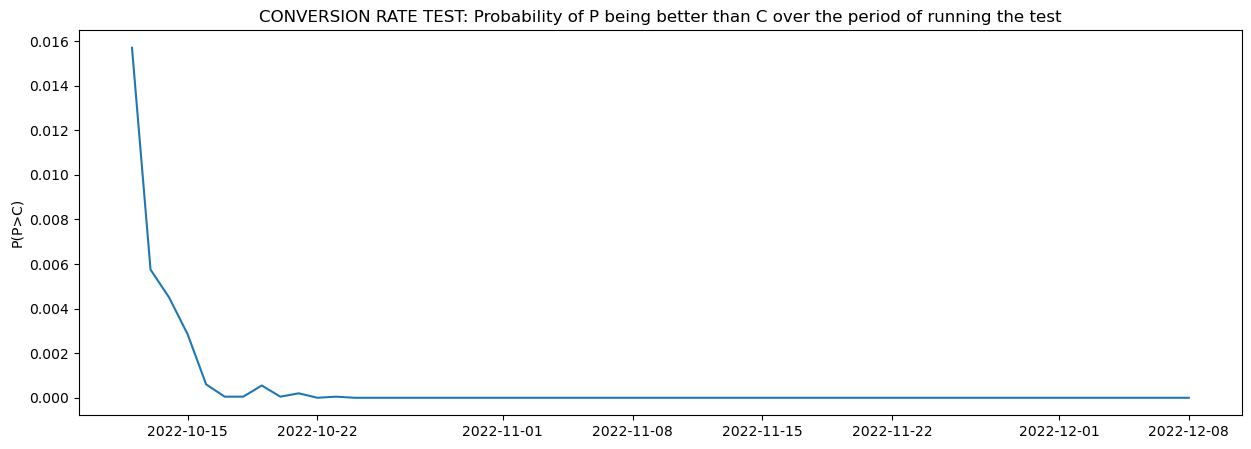

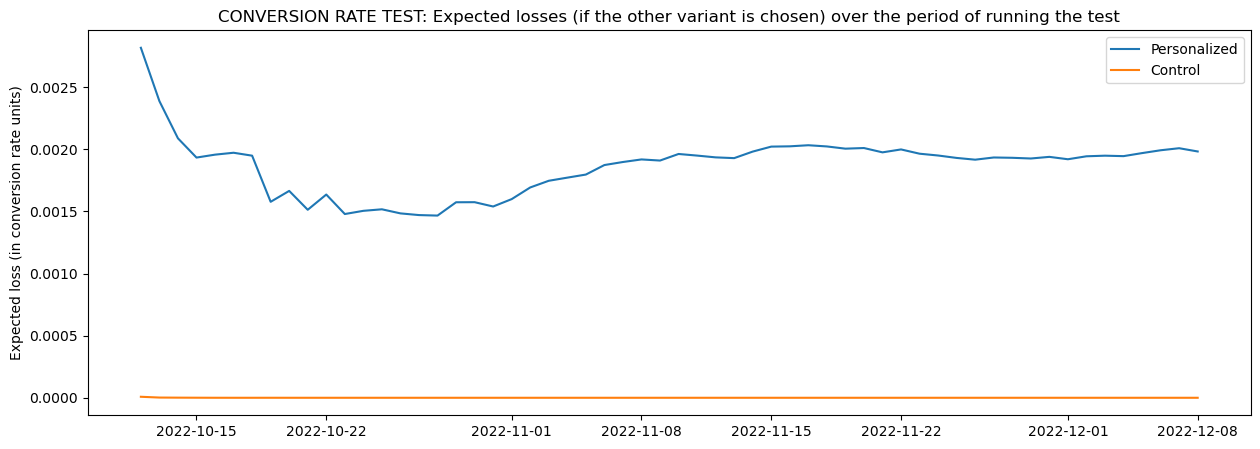

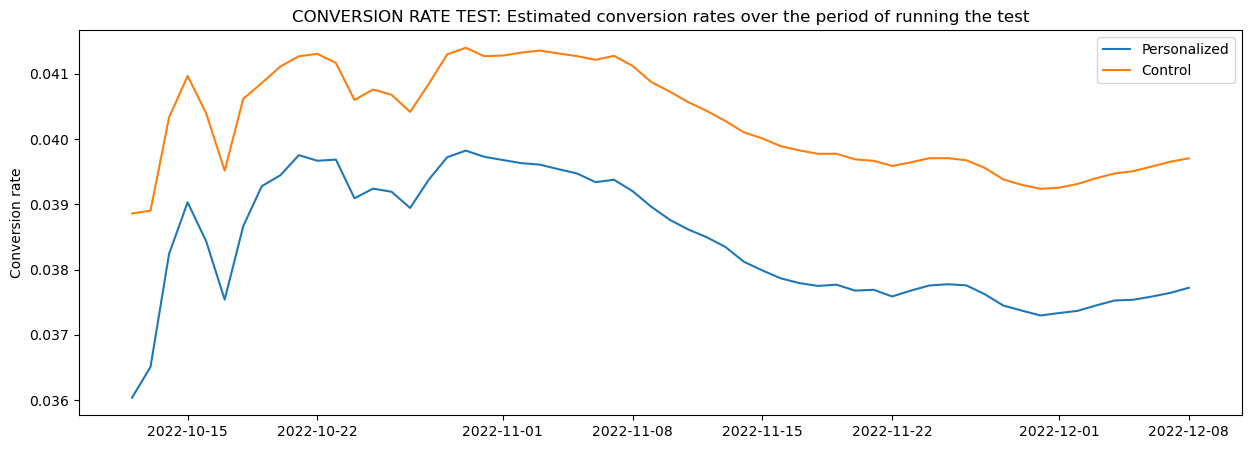

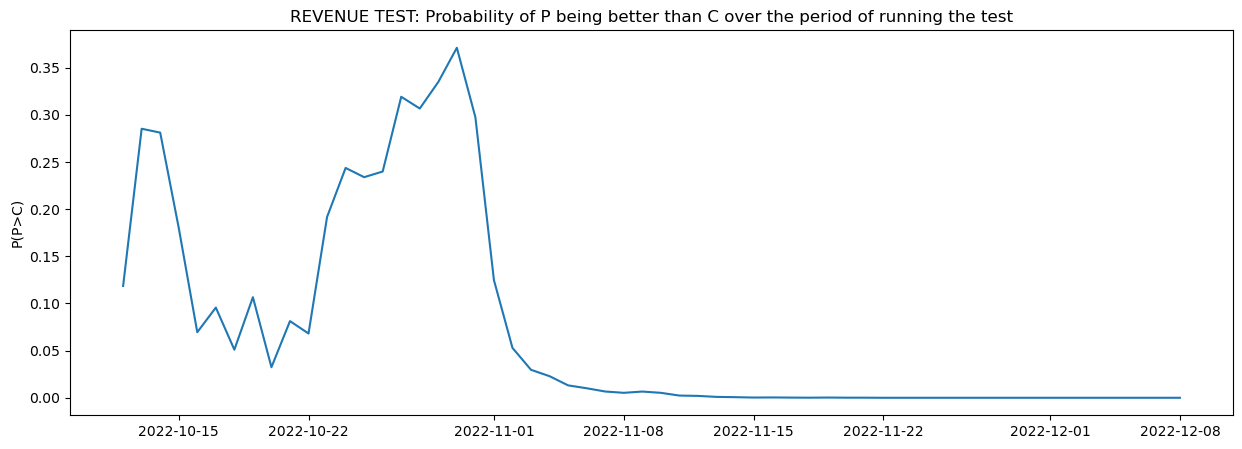

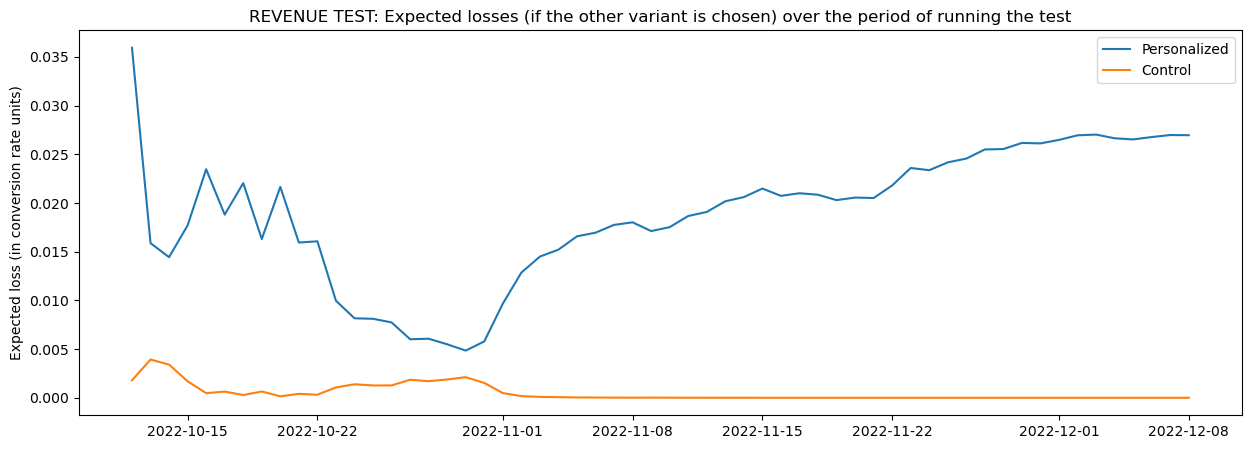

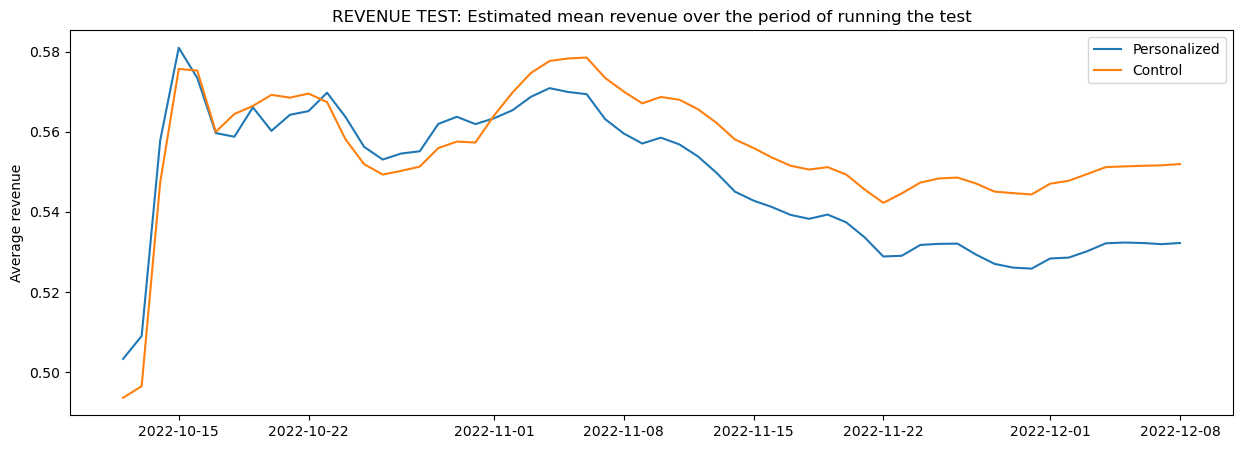

In [4]:
client_name = 'bingo_aloha'

start_date = datetime(2022,10,12)
end_date = datetime(2022,12,8)
dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        queries_dict[client_name]
    )

run_ab_testing(initial_data, dates_list)

# Idle mafia

2022-12-11 15:25:57,131 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:443.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:4021.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:31798476|c


2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00


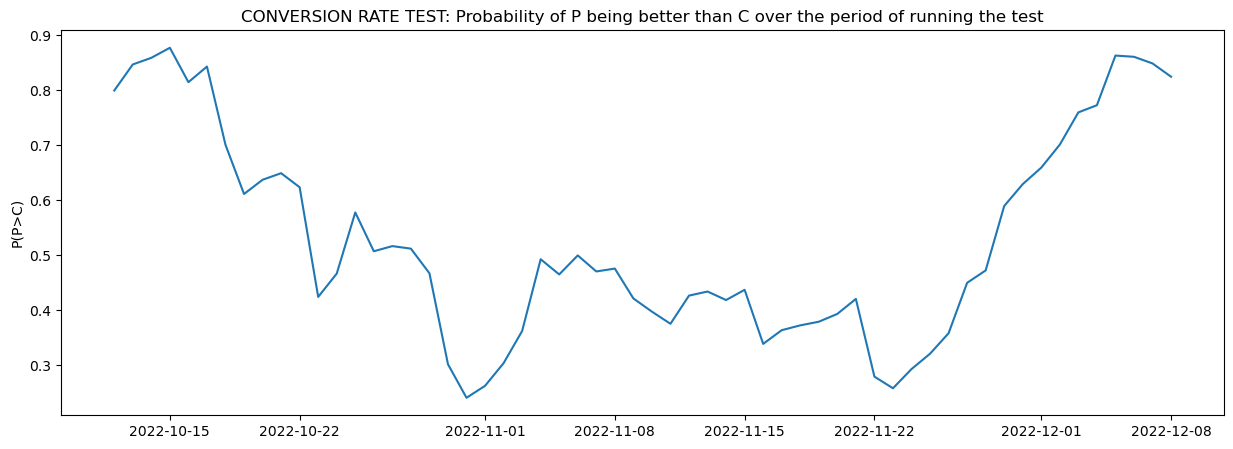

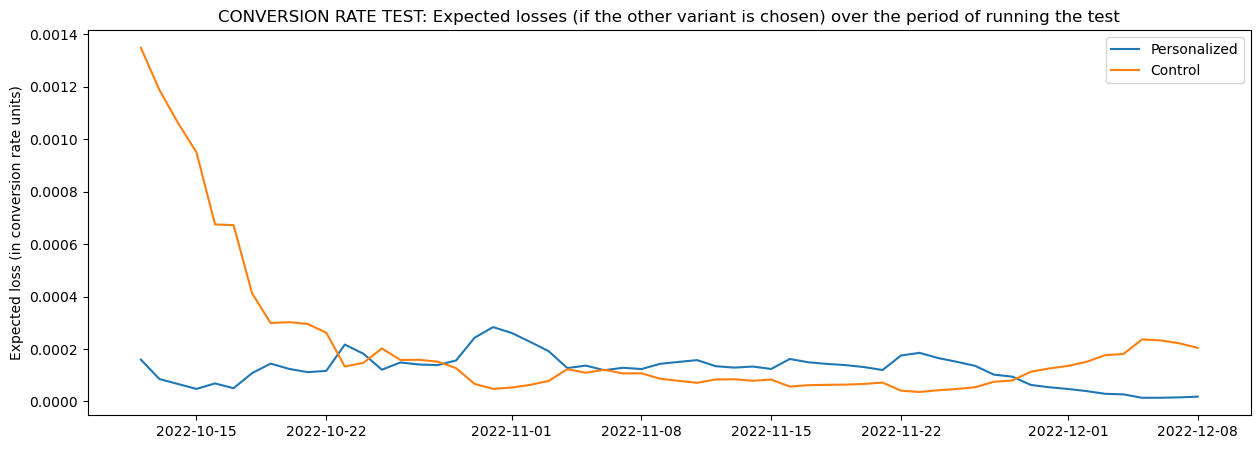

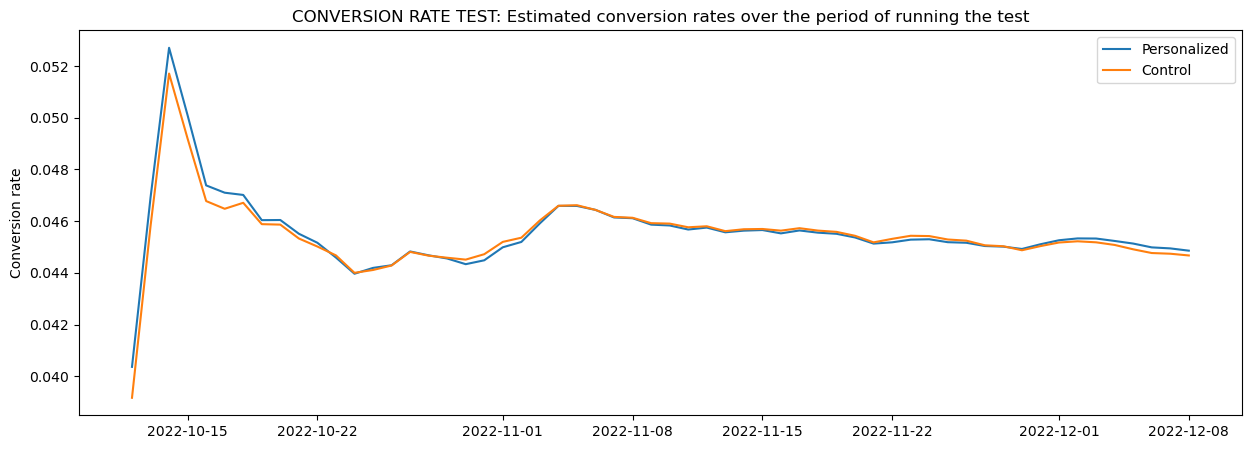

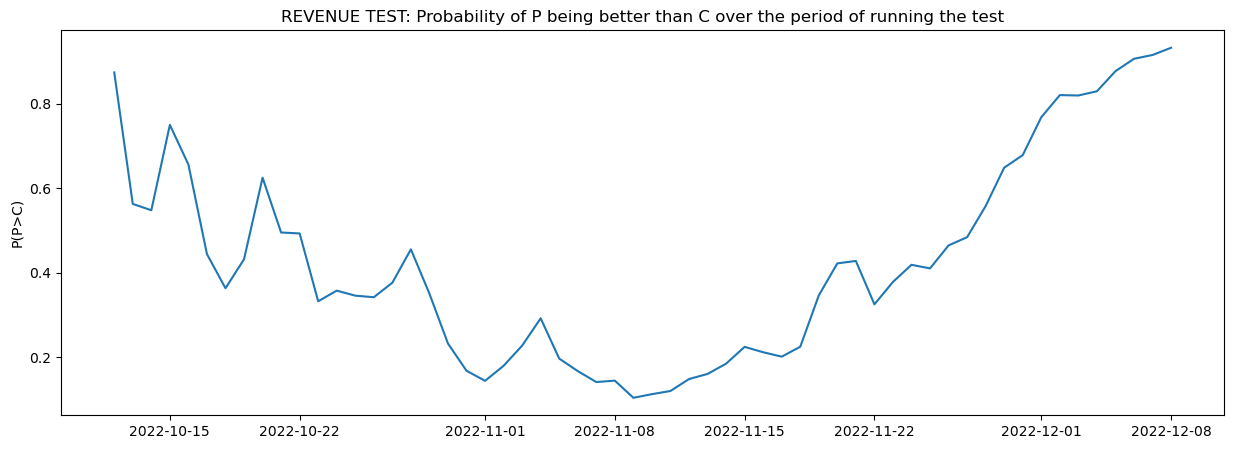

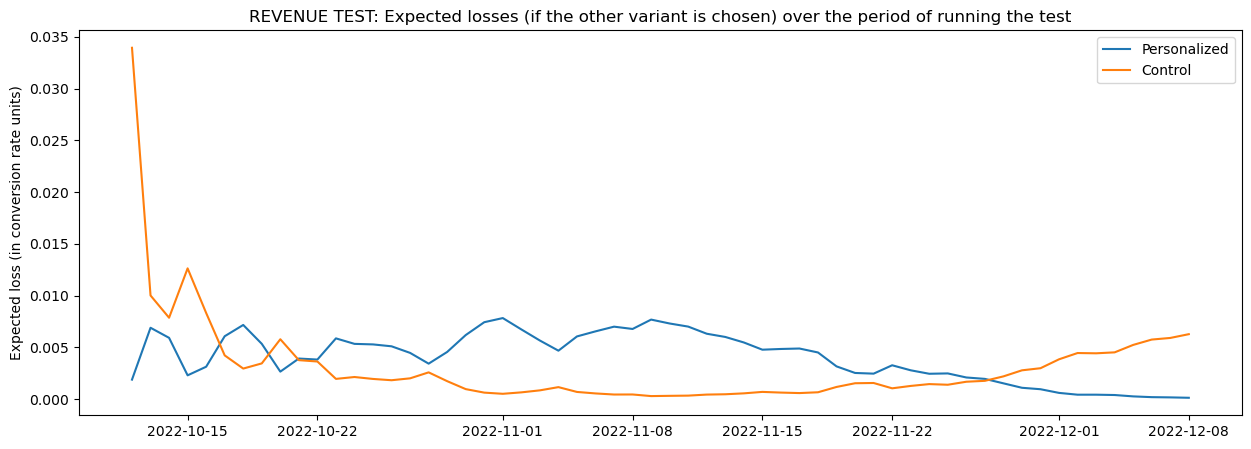

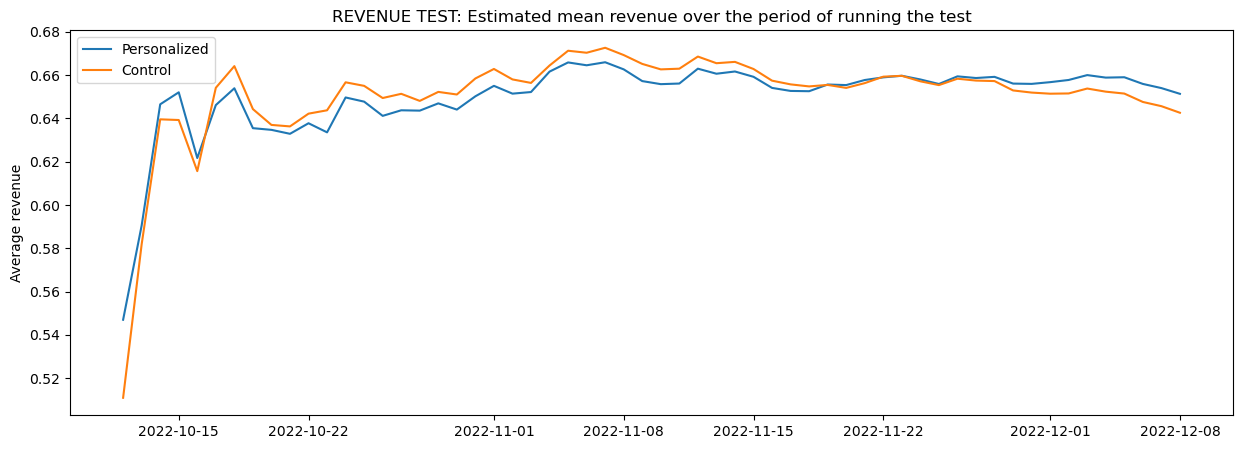

In [5]:
client_name = 'idle_mafia'

start_date = datetime(2022,10,12)
end_date = datetime(2022,12,8)
dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        queries_dict[client_name]
    )

run_ab_testing(initial_data, dates_list)

# Tinysoft

2022-12-11 15:27:36,336 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:465.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:3794.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:52866009|c


2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00


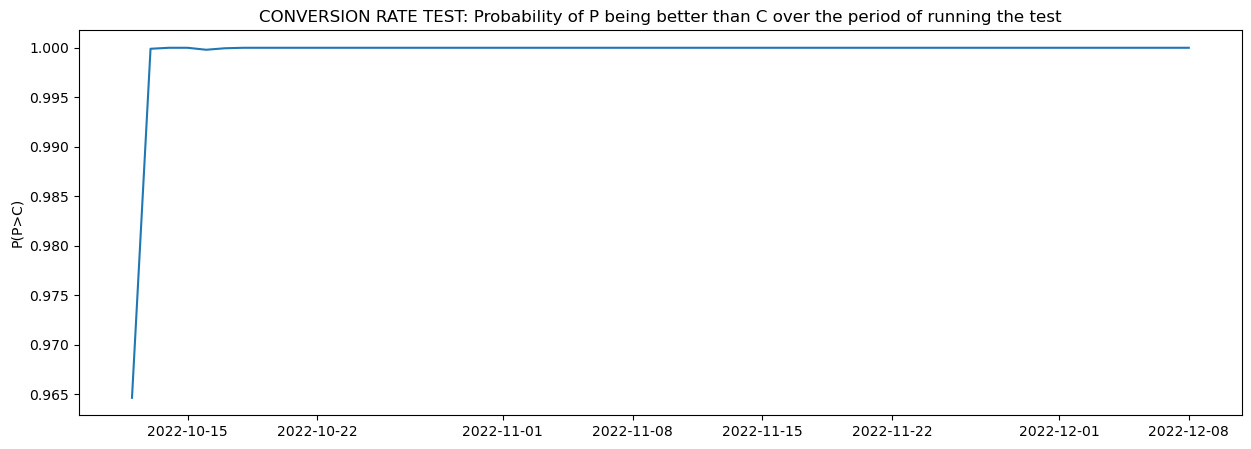

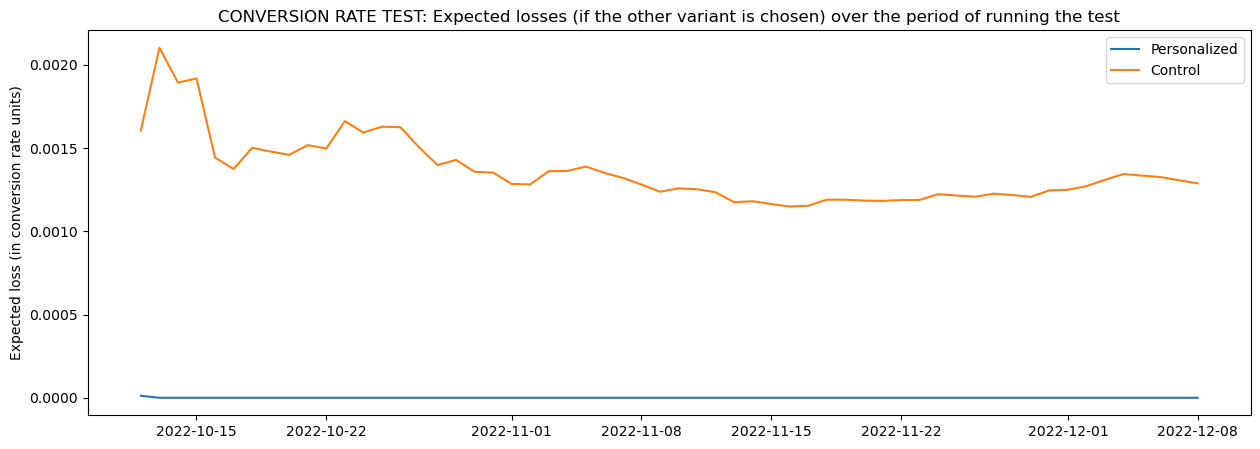

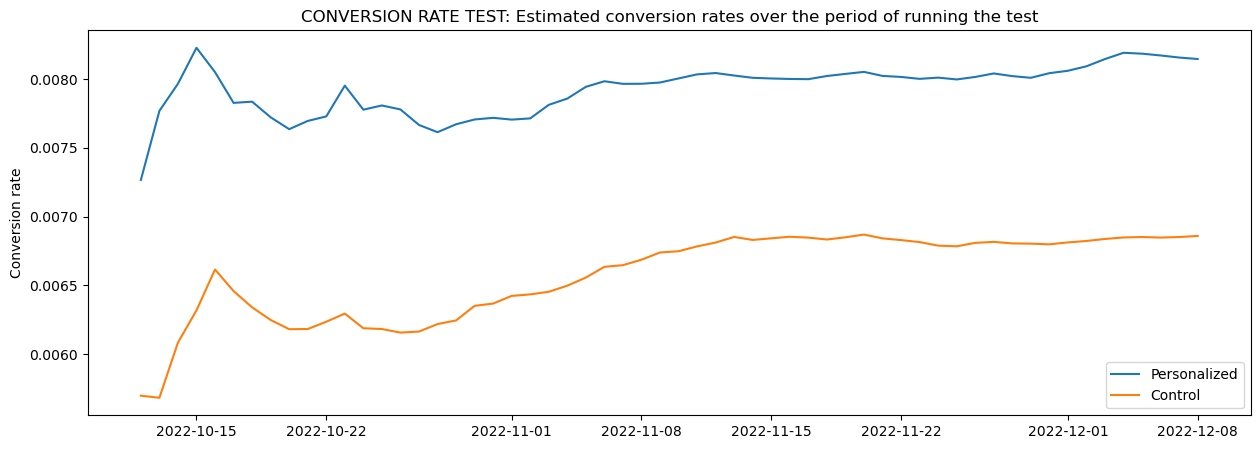

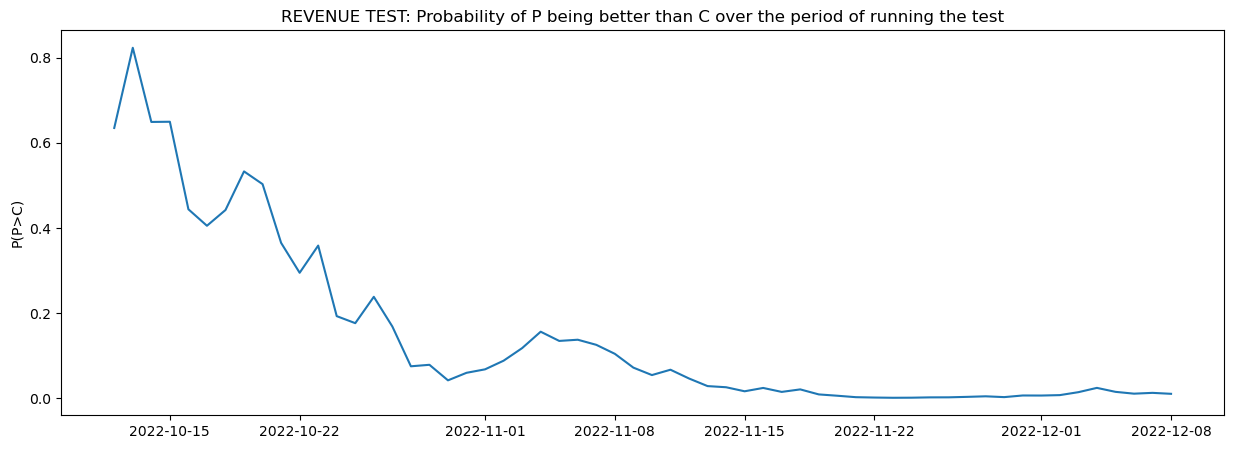

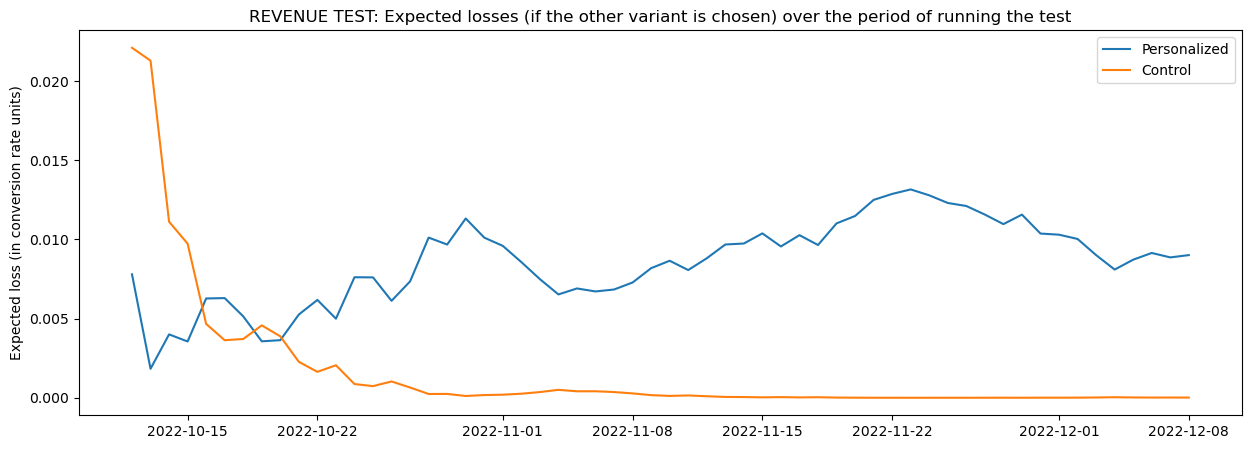

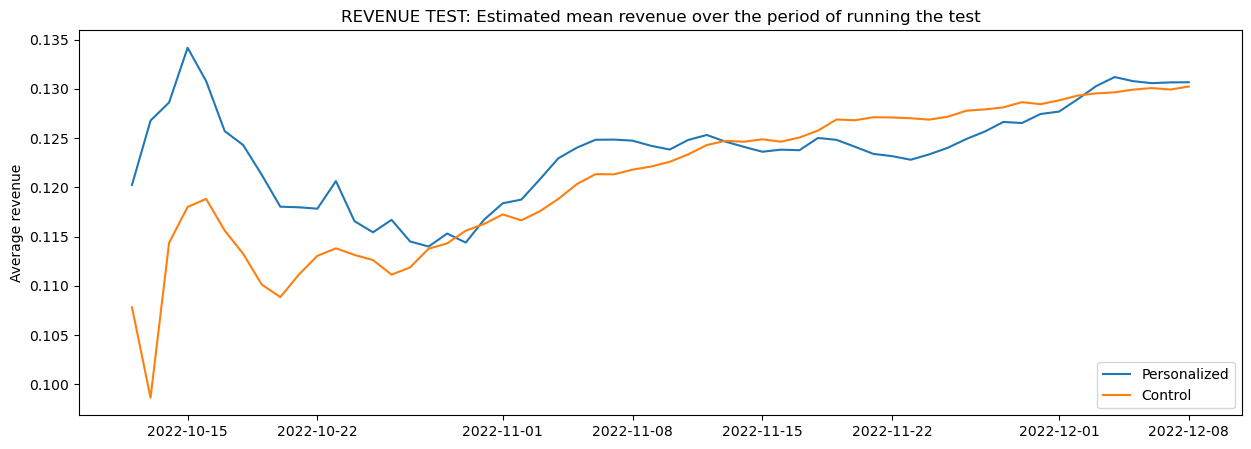

In [6]:
client_name = 'homw'

start_date = datetime(2022,10,12)
end_date = datetime(2022,12,8)
dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        queries_dict[client_name]
    )

run_ab_testing(initial_data, dates_list)

# Spongebob

2022-12-11 15:29:09,072 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:485.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:3852.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:38885461|c


2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00


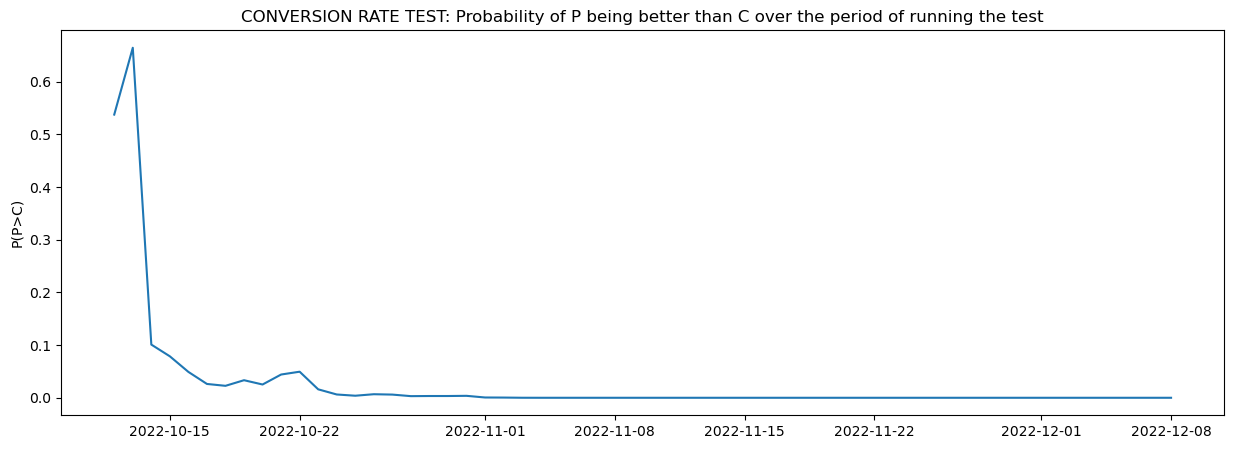

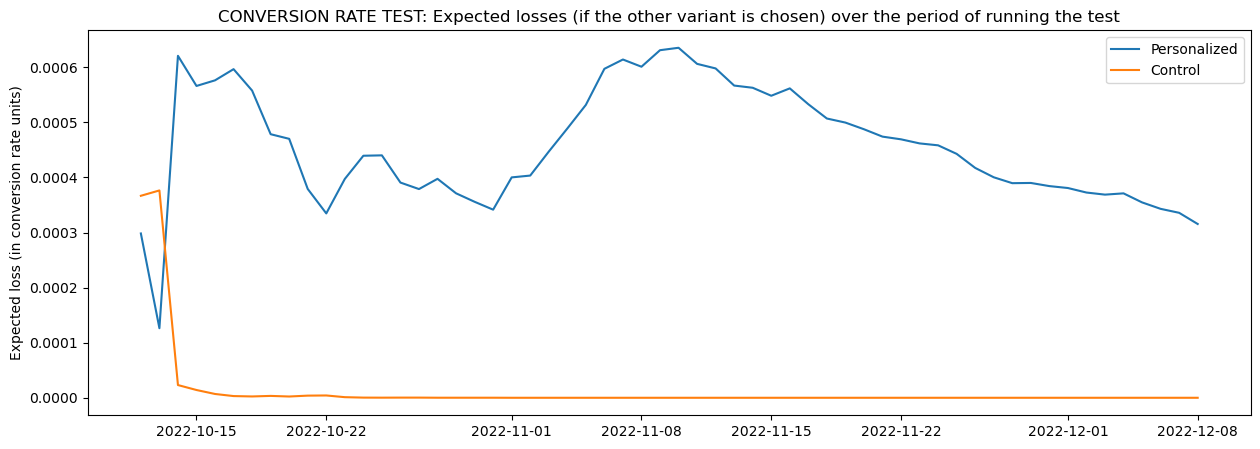

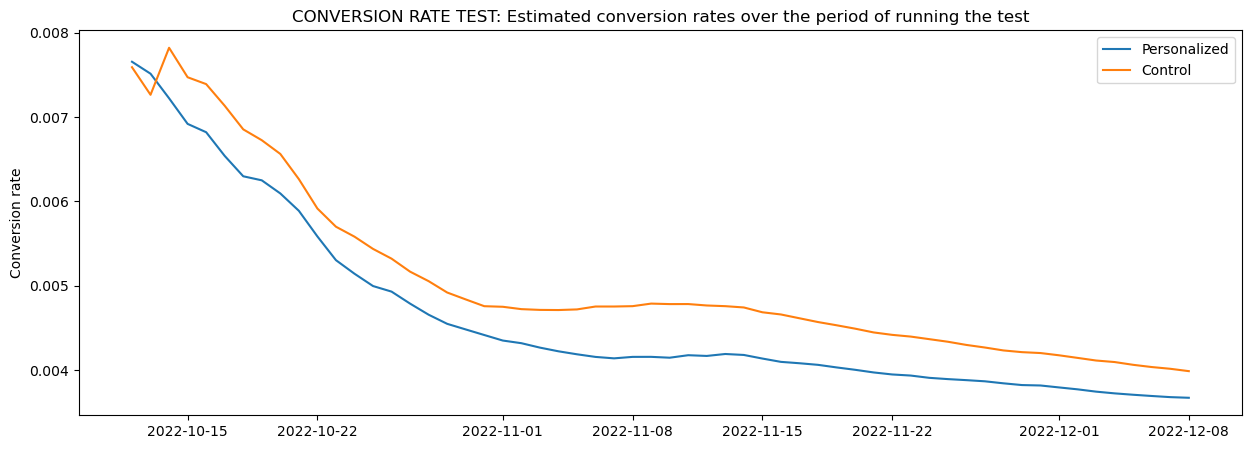

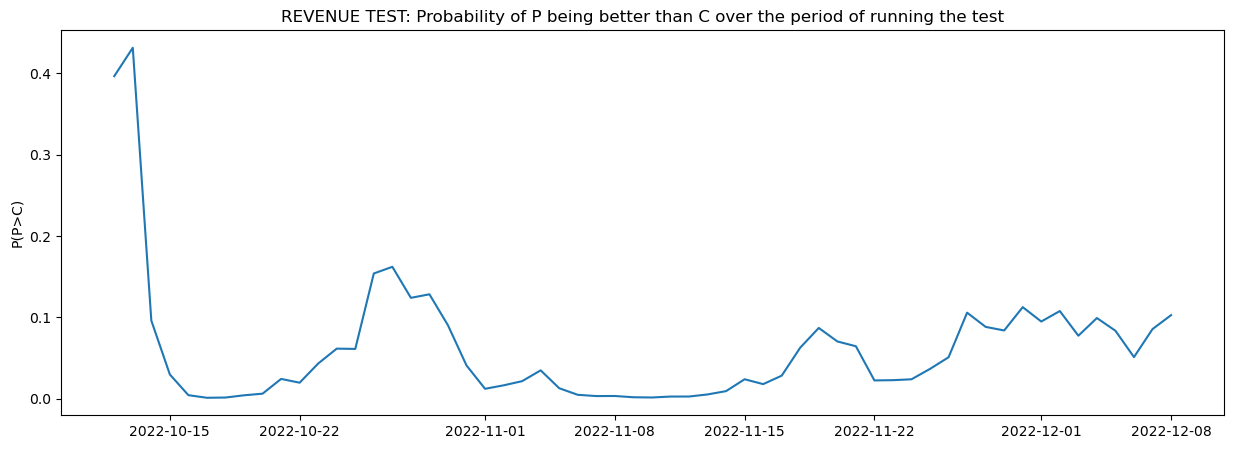

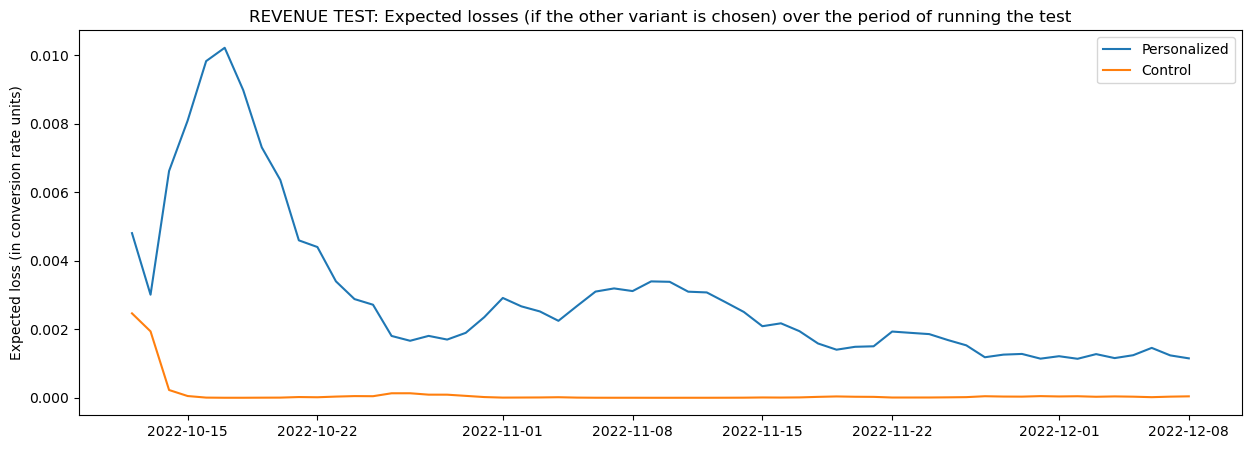

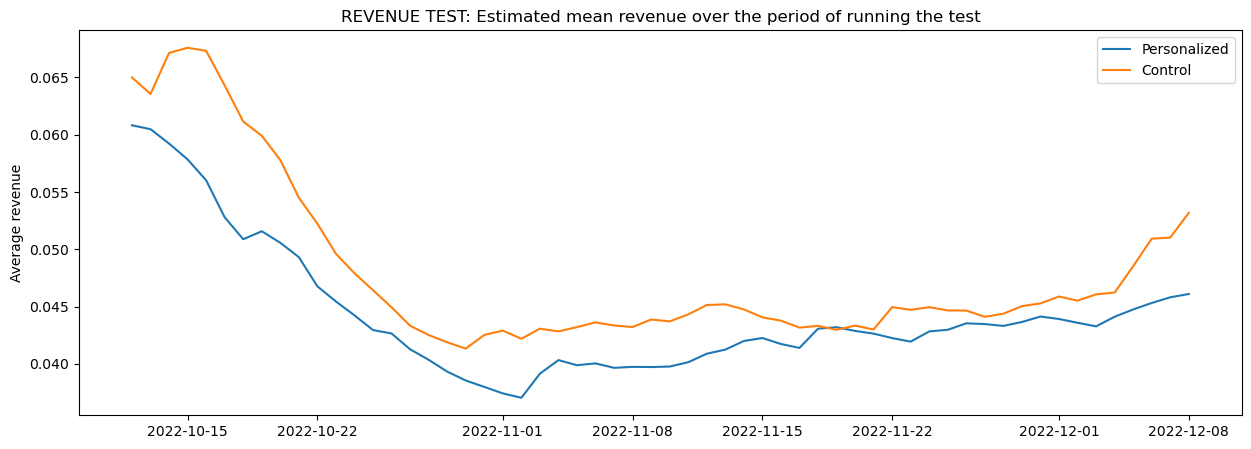

In [7]:
client_name = 'spongebob'

start_date = datetime(2022,10,12)
end_date = datetime(2022,12,8)
dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        queries_dict[client_name]
    )

run_ab_testing(initial_data, dates_list)

# Terragenesis

2022-12-11 15:30:44,677 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:492.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:3635.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:27908045|c


2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00


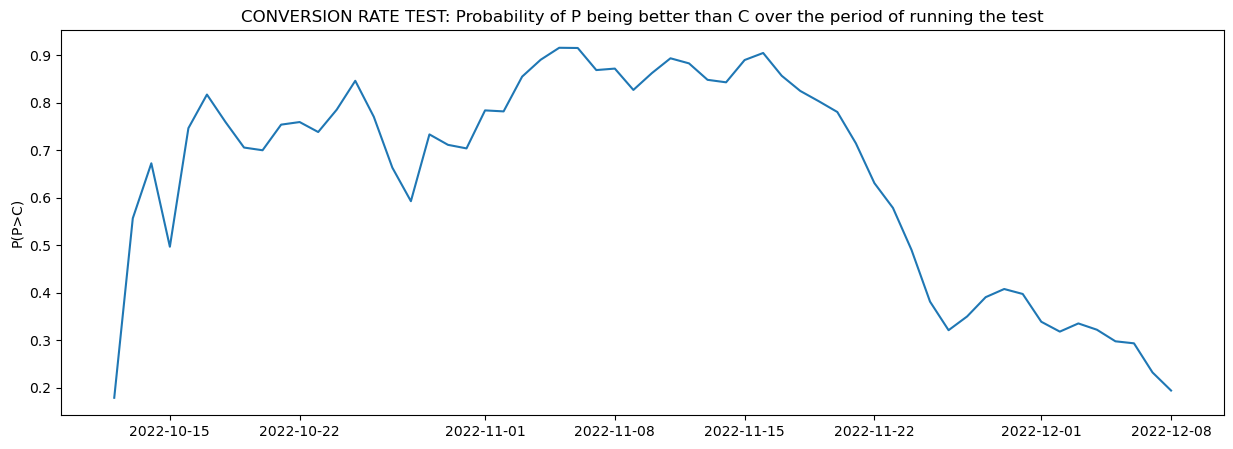

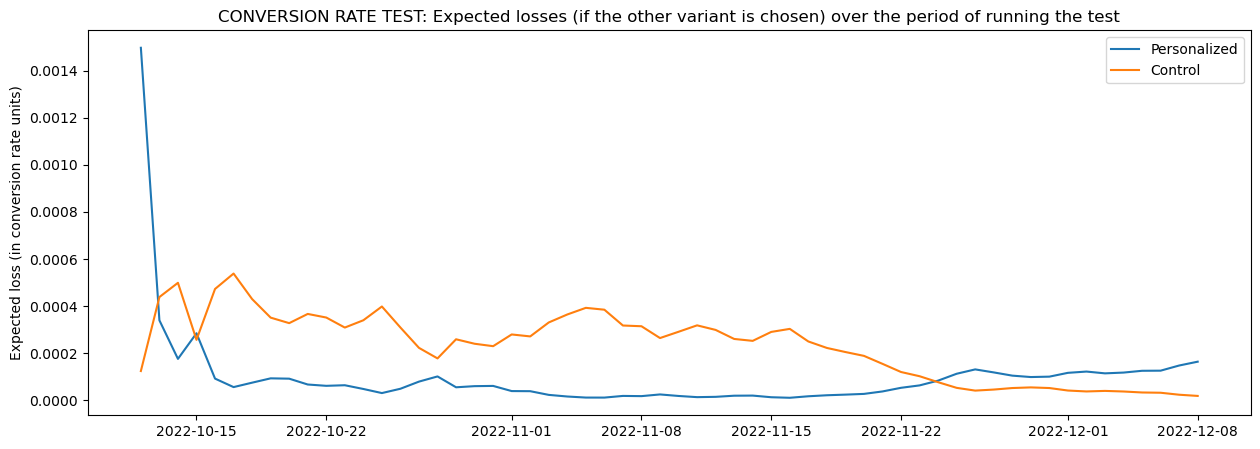

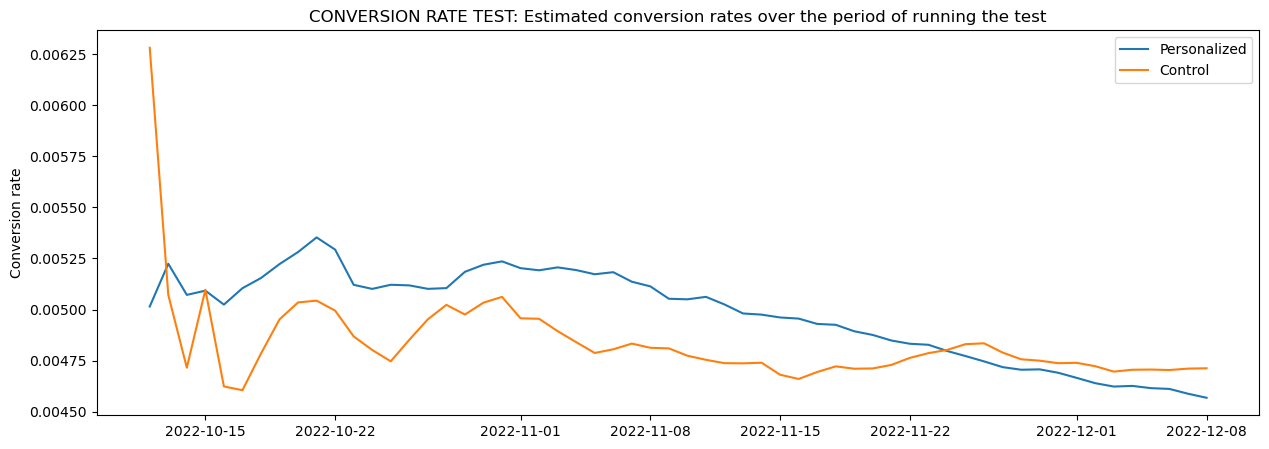

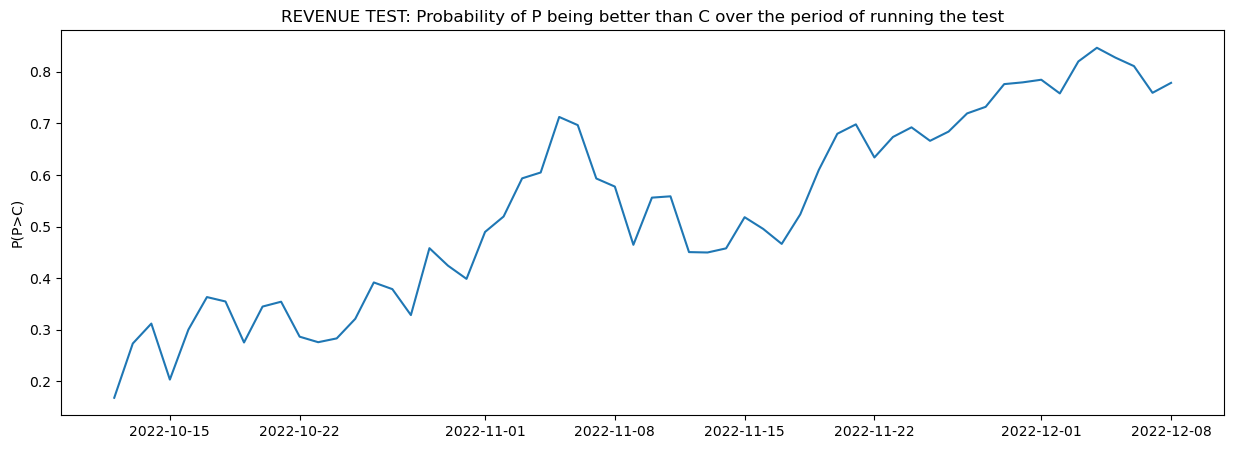

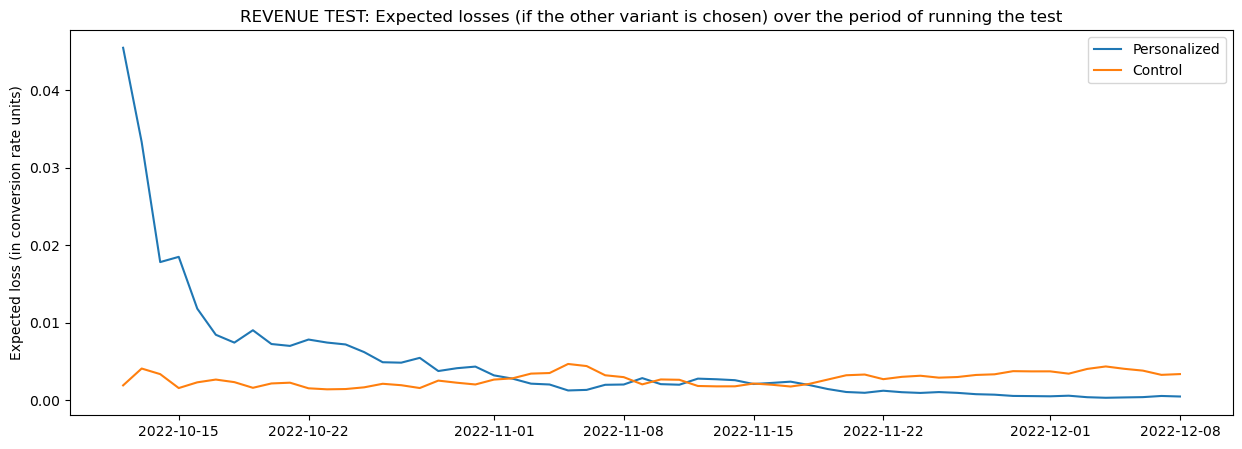

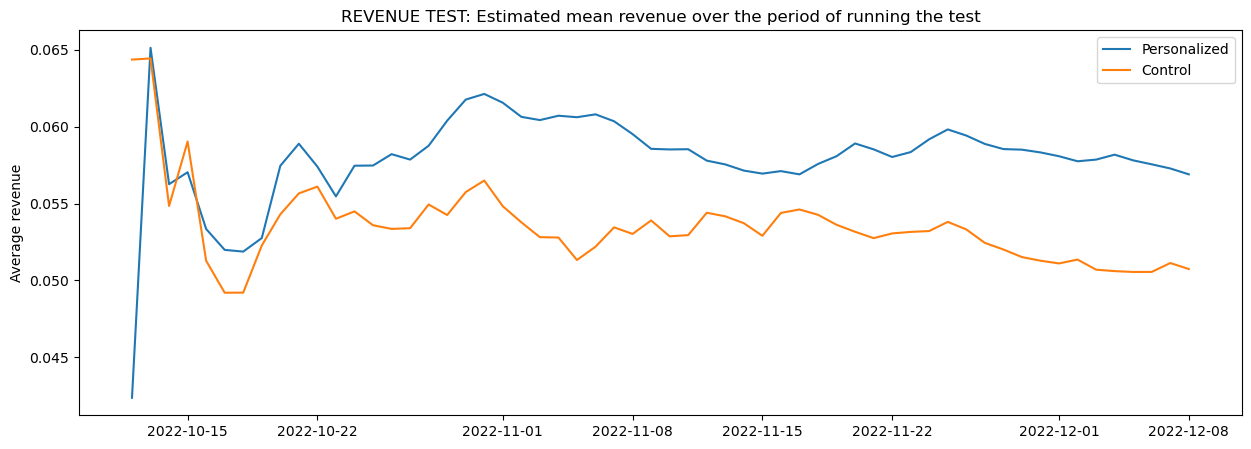

In [8]:
client_name = 'terra_genesis'
start_date = datetime(2022,10,12)
end_date = datetime(2022,12,8)
dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        queries_dict[client_name]
    )

run_ab_testing(initial_data, dates_list)